# Project: Identify Customer Segments

The following project applies various unsupervised learning techniques to identify segments of the population that form the customer base for a mail-order sales company in Germany (Arvato Bertelsmann). 

These segments can then for example be used to examine the customer base and direct marketing campaigns towards audiences that will have the highest expected rate of returns as one business example. The data has been provided by Bertelsmann Arvato Analytics and represents a typical task of their Data Scientists work.  

The data is proprietary and was deleted after finishing the project for the Data Scientist Nanodegree program offered by Udacity. To give a good impression of the data I introduce it in detail and show important aspects.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import functions
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
from sklearn.preprocessing import LabelEncoder

# Visualization in notebook
%matplotlib inline

## Part 1: Data and Preprocessing

### Load the Data

There are four files associated with this project:

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. We will use this information to cluster the general population into groups with similar demographic properties. 

Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

First, we'll load two files that will be examined. The general demographics data and an additional data containing information about the features. 

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

#### General demographics data (azdias)

In [3]:
# Shape of azdias
print("Structure 'azdias': ")
azdias.shape

Structure 'azdias': 


(891221, 85)

Dataset has `891221` rows and `85`columns indicating no. of individuals and features, respectively.

In [4]:
# Head of azdias
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### The feature dataset (feat_info)
Contains 4 characteristics of the respective features of `azdias`.

In [5]:
# Head of feat_info
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


Note in particular how the **type** is structured and how **missingness** is encoded here.

In [6]:
# Shape of feat_info:
print("\nShape: ", feat_info.shape)

# Unique information level of feat_info
print("\nInformation level: ",feat_info["information_level"].unique())

# Unique data type categories
print("\nData type: ", feat_info["type"].unique())


Shape:  (85, 4)

Information level:  ['person' 'household' 'building' 'microcell_rr4' 'microcell_rr3'
 'postcode' 'region_rr1' 'macrocell_plz8' 'community']

Data type:  ['categorical' 'ordinal' 'numeric' 'mixed' 'interval']


In [7]:
# Show feature info by information level
print(feat_info.groupby(by="information_level").size())

# ...and by type
print("\n",feat_info.groupby(by="type").size())

information_level
building           7
community          3
household          7
macrocell_plz8     8
microcell_rr3      6
microcell_rr4      3
person            43
postcode           3
region_rr1         5
dtype: int64

 type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64


**Notes**  
There are 43 features directly related to the person, whereas other features are on the household (7) or community (3) level. 

Moreover, the data features have different measurement scales. Of the 85 features, 49 are ordinally scaled, 21 categorically and the rest of the features are either interval, mixed or numerically scaled. It seems reasonable to have a look at the individually measurement scales later on and process them further.

## Preprocessing
We'll have a detailed look at how to preprocess this data. Later on I'll bring all these steps together in a compact function... 

### Missing data
Different value codes indicate missing or unknown data. We will convert them consistently to NaN. Value from the data dictionary that indicate missing or unknown data can be found in `feat_info` (see fourth col above).

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
for index in feat_info.index:
    feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
    
    for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
        try:
            feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
        except:
            continue
            
    azdias.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)

**Notes**  
This complicated looking animal compared the values to how missing or unknown data are indicated in `feat_info` by the col. `missing_or_unknown`. Then, it replaces these value codes to NaN. There may be a more intuitive or straight-forward way of doing this and I happily accept suggestions to simplify this part. 

In [9]:
# Just checking in ...
azdias.loc[1:10]

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,NaN,3.0,2,1.0,2,2,5,3,1,5,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


---
#### Assess Missing Data in Each Column
Questions to answer:
- How much missing data is present in each column?
- Outliers in terms of the proportion of values that are missing?
- Are there any patterns in which columns have, or share, missing data?

In [10]:
# Aggregate NaNs
col_missings = azdias.isnull().sum()

# Create sorting index many to none
sort_index = np.argsort(-col_missings)

# Show NaNs per col by sort_index
col_missings_sort = col_missings.iloc[sort_index]
print("Missings per column: (many to none)\n")
print(col_missings_sort)

# Total number of NaNs
print("\nTotal NaN: ", azdias.isnull().sum().sum())

Missings per column: (many to none)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
PLZ8_BAUMAX              116515
PLZ8_GBZ                 116515
PLZ8_ANTG1               116515
PLZ8_ANTG2               116515
PLZ8_ANTG3               116515
PLZ8_ANTG4               116515
PLZ8_HHZ                 116515
VERS_TYP                 111196
HEALTH_TYP               111196
SHOPPER_TYP              111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
   

In [11]:
# Calculate percentage of NaN wrt total entries
total_missings = azdias.isnull().sum().sum()
total_entries = azdias.shape[0]*azdias.shape[1]
print("Entries missing: {:.2f}%".format( (total_missings / total_entries) * 100) )

Entries missing: 11.05%


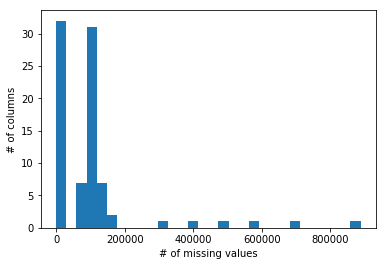

In [12]:
# Investigate patterns in the amount of missing data in each column.
#Use hist to identify columns with higher proportion of missings
plt.hist(col_missings, bins = 30)
plt.xlabel("# of missing values")
plt.ylabel("# of columns")

plt.show()

**Notes**
Based on the histogram it seems as there is a gap between cols with more and fewer 159k NaNs.

In [13]:
# Show cols with more than 159 
print("Cols given more than 159k missings:\n", col_missings_sort[col_missings_sort > 159000])

# Show missing percentages of those columns with more than 159k NaNs. 
print("\nCols given more than 159k missings (NaNs relative to toal entries):\n", (col_missings_sort[col_missings_sort > 159000] / azdias.shape[0])*100)

Cols given more than 159k missings:
 TITEL_KZ        889061
AGER_TYP        685843
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
ALTER_HH        310267
dtype: int64

Cols given more than 159k missings (NaNs relative to toal entries):
 TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64


**Notes**:  
It seems as if there is a clear gap between columns with fewer than 159k missing values and the 6 columns with more than 310k missing values per column. There is not a single column where the number of NaNs is between 159k (~17%) and 310k (~35%).

The first column with more than 159k missings (ascending order) is `ALTER_HH` with 310,267 missing values or roughly 35%. The column with the most missing values is `TITEL_KZ` and has 889061 missing values (Recall from the shape that we have 891221 data entries). Hence, almost all data for this category are missing, except 2160. In percentage this means that 99.7% of the data are missing or unknown!

In [14]:
# Overview of missings per col.
col_missings.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [15]:
# How many columns have no missings at all?
no_missings = len(col_missings[col_missings == 0])
print("{} columns without missings!".format(no_missings))

24 columns without missings!


**Notes**  
The 85 columns have on average ~98,5k missing values, whereas the median is a little bit lower at ~93,1k missing values indicating that the distribution is right-skewed. Next step:
- Identify and delete outlier columns. 

This is slightly subjective but at least 35% of the data in the respective columns are missing and we want to simplify the Analysis for now.

In [16]:
# Identifying "outlier columns"
col_outlier = col_missings[col_missings > 159000]
col_outlier_names = col_missings[col_missings > 159000].index
print(col_outlier)
print("\nOutlier columns: \n", col_outlier_names)

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64

Outlier columns: 
 Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


**Notes**  
Delete the following columns, which have been identified as outliers:  
- AGER_TYP
- GEBURTSJAHR
- TITEL_KZ
- ALTER_HH
- KK_KUNDENTYP
- KBA05_BAUMAX

In [17]:
# Remove the outlier columns from the dataset. 
azdias = azdias.drop(col_outlier_names, axis =1) # could also be done using inplace but I prefer it this way
print("New shape: ",azdias.shape)

# Calculate NaNs after deleting cols
col_missings2 = azdias.isnull().sum()

# Print Total NaNs after deleting the columns
print("No. of total NaNs after deleting columns:",col_missings2.sum())

# Print percentage of NaNs to all remaining entries
rel_NaN = (col_missings2.sum() / (azdias.shape[0] * azdias.shape[1]))*100
print("Percent of NaNs: ", round(rel_NaN,2), "%")

# Descriptive stats of NaNs after deleting columns
col_missings2.describe()

New shape:  (891221, 79)
No. of total NaNs after deleting columns: 5035304
Percent of NaNs:  7.15 %


count        79.000000
mean      63738.025316
std       54253.866391
min           0.000000
25%           0.000000
50%       93148.000000
75%      108239.500000
max      158064.000000
dtype: float64

**Notes**  
- Before deleting the 6 columns we had `8373929` missing values
- After deleting we have `5035304` missing values left.
- Mean of missing values decreased to ~63,7k missing values.

#### Notes on Assessing Missing Data in Each Column
The raw dataset contains 891,221 rows and 85 columns indicating no. of individuals and features, respectively.

Its features are categorized by level of collection and measurement scales (type). There are 43 features collected on the personal level, whereas other features are for example collected on the household (7) or community (3) level. 

Moreover, the data features have different measurement scales. Of the 85 features, 49 are ordinally scaled, 21 categorically and the rest of the features are either interval, mixed or numerically scaled. It seems reasonable to have a look at the individually measurement scales later on and process them further.

After changing the code for missings to nan it becomes visible that the dataset contains 8,373,929 missing or unknown values (11.05%). In the following analysis missing and unknown values are treated equally and the terms `missing` and `unknown` are interchangeably. 

Additionally, it can be seen that there is a clear gap between columns with fewer than 159k missing values and 6 columns with more than 310k missing values per column. Again, there are no columns with  missing values between 159k (~17%) and 310k (~35%).

The first column with more than 159k missings (ascending order) is `ALTER_HH` with 310,267 missing values or ~35%. The column with the most missing values is `TITEL_KZ` and has 889,061 missing values (Recall from the shape that we have 891,221 data entries). Hence, almost all data for this category are missing, except 2,160. More than 99.7% of the data are missing in this column!

The 85 columns have on average ~98,5k missing values, whereas the median is a little bit lower at ~93,1k missing values indicating that the distribution is right-skewed. In total, 11.05% of the entries are missing or unknown. Based on the aforementioned huge gap I decided to delete all columns with more than 159,000 missing values. 

Hence, I deleted the following columns, which I have identified as outliers:  
- AGER_TYP
- GEBURTSJAHR
- TITEL_KZ
- ALTER_HH
- KK_KUNDENTYP
- KBA05_BAUMAX

Before deleting the 6 columns we had 8,373,929 missing values, whereas after deleting them  5,035,304 missing values are left. This decreased the mean of missing values to ~63,7k. In total 7.15% (-3.9) of the data are now missing or unknown. 

--- 
####  Assess Missing Data in Each Row
Next, we'll assess NaNs in each row. The questions are similar to the previous task but now we'll focus on the rows. Again, we'll have a look at basic statistics and, in particular, outliers. Are there outlier rows and are these outliers inherently different from the rest of the sample?

In [18]:
# How much data is missing in each row of the dataset?
row_missings = azdias.isnull().sum(axis=1)
row_missings.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [19]:
# Missings per quantile
for i in range(50,100,5):
    print("0."+str(i), "Quantile", np.percentile(row_missings,i))

0.50 Quantile 0.0
0.55 Quantile 0.0
0.60 Quantile 0.0
0.65 Quantile 0.0
0.70 Quantile 1.0
0.75 Quantile 3.0
0.80 Quantile 5.0
0.85 Quantile 8.0
0.90 Quantile 34.0
0.95 Quantile 47.0


**Notes**  
After deleting the outlier columns we have on average 5.7 missing values per row. Moreover, the 0.5 quantile (median) as well as the 0.65 quantile is zero. Hence, for 65% of the rows we have the complete feature set. Additionally, even the 0.85 Quantile is only 8, indicating that 85% of the rows have only 8 or fewer missings. One observation is that few rows account for a lot of the NaNs in the data. We will investigate whether those individual observations with many missings are inherently different from the rest of the observations. For now we have a closer look at rows with fewer or equal 5 NaNs.

Rows with fewer or equal 5 NaNs: 719624
Rows with more than 5 NaNs: 171597
19.25 % of the rows have more than 5 NaNs.


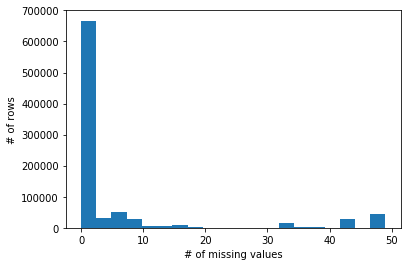

In [20]:
# How many rows have fewer or equal 5 NaNs vs more than 5 NaNs?
print("Rows with fewer or equal 5 NaNs:",len(row_missings[row_missings <= 5]))
print("Rows with more than 5 NaNs:", len(row_missings[row_missings > 5]))

# Calculate how many rows have more than 5 NaNs (in percent)
rows_NaNs_perc = 100 - ((len(row_missings[row_missings <= 5])/len(row_missings))*100)
print(round(rows_NaNs_perc,2), "% of the rows have more than 5 NaNs.")

# Histogram of NaNs per row
plt.hist(row_missings, bins = 20)
plt.xlabel("# of missing values")
plt.ylabel("# of rows")
plt.show()

**Notes**  
There are a lot of rows with (almost) no Nans. Moreover, nearly no row has between 20 - 30 NaN values. Then again, at the right side of the distribution we see that some rows have 30 and more unknown or missing values per rows.

In [21]:
# Rows missings with <= 20 vs. > 20 NaNs
print("Row missings fewer or equal 20:\n",len(row_missings[row_missings <= 20]))
print("Row missings more than 20:\n", len(row_missings[row_missings > 20]))

# Calculate share
few_NaNs = (len(row_missings[row_missings <= 20]) / len(row_missings))*100
print("Twenty or fewer missings values per row:",round(few_NaNs, 2),"%")

Row missings fewer or equal 20:
 797426
Row missings more than 20:
 93795
Twenty or fewer missings values per row: 89.48 %


**Notes**  
In addition it seems as there is a gap betwen 20 and 30 missing values per row as almost 90% of rows have fewer than 20 missing values. 

In [22]:
# Function to split the data according to indicated missings per row
def subset_row_missings(missings_per_row=20):
    """
    Input: int >= 0 as value to split the data in two subsets
    Results in two subsets of azdias, where sub1 has <= missings_per_row
        and sub2 consists of rows > missings_per_row"""
    
    idx_be = row_missings.index[row_missings <= missings_per_row]
    idx_ab = row_missings.index[row_missings > missings_per_row] 
    sub1 = azdias.loc[idx_be]
    sub2 = azdias.loc[idx_ab]
    return sub1, sub2

sub1, sub2 = subset_row_missings(20)

In [23]:
# Check shape and size of subsets
print("Shape of complete dataset : ", azdias.shape)
print("Rows with fewer or equal 20 missings: ", sub1.shape[0])
print("Rows with more than 20 missings: ", sub2.shape[0])

Shape of complete dataset :  (891221, 79)
Rows with fewer or equal 20 missings:  797426
Rows with more than 20 missings:  93795


#### Compare subsets
Next step is to compare the two subsets and if they indicate inherent differences. First, visually inspect differences with 5 randomly chosen features

In [24]:
# Choose (random) cols
import random

# Uncomment if you want 5 random cols
# five_cols = azdias.columns[np.random.randint(0, 79,5)]

five_cols = (["GREEN_AVANTGARDE", 
              "FINANZTYP", 
              "FINANZ_ANLEGER", 
              "SEMIO_PFLICHT", 
              "ZABEOTYP", 
              ])

C:\Users\TM\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


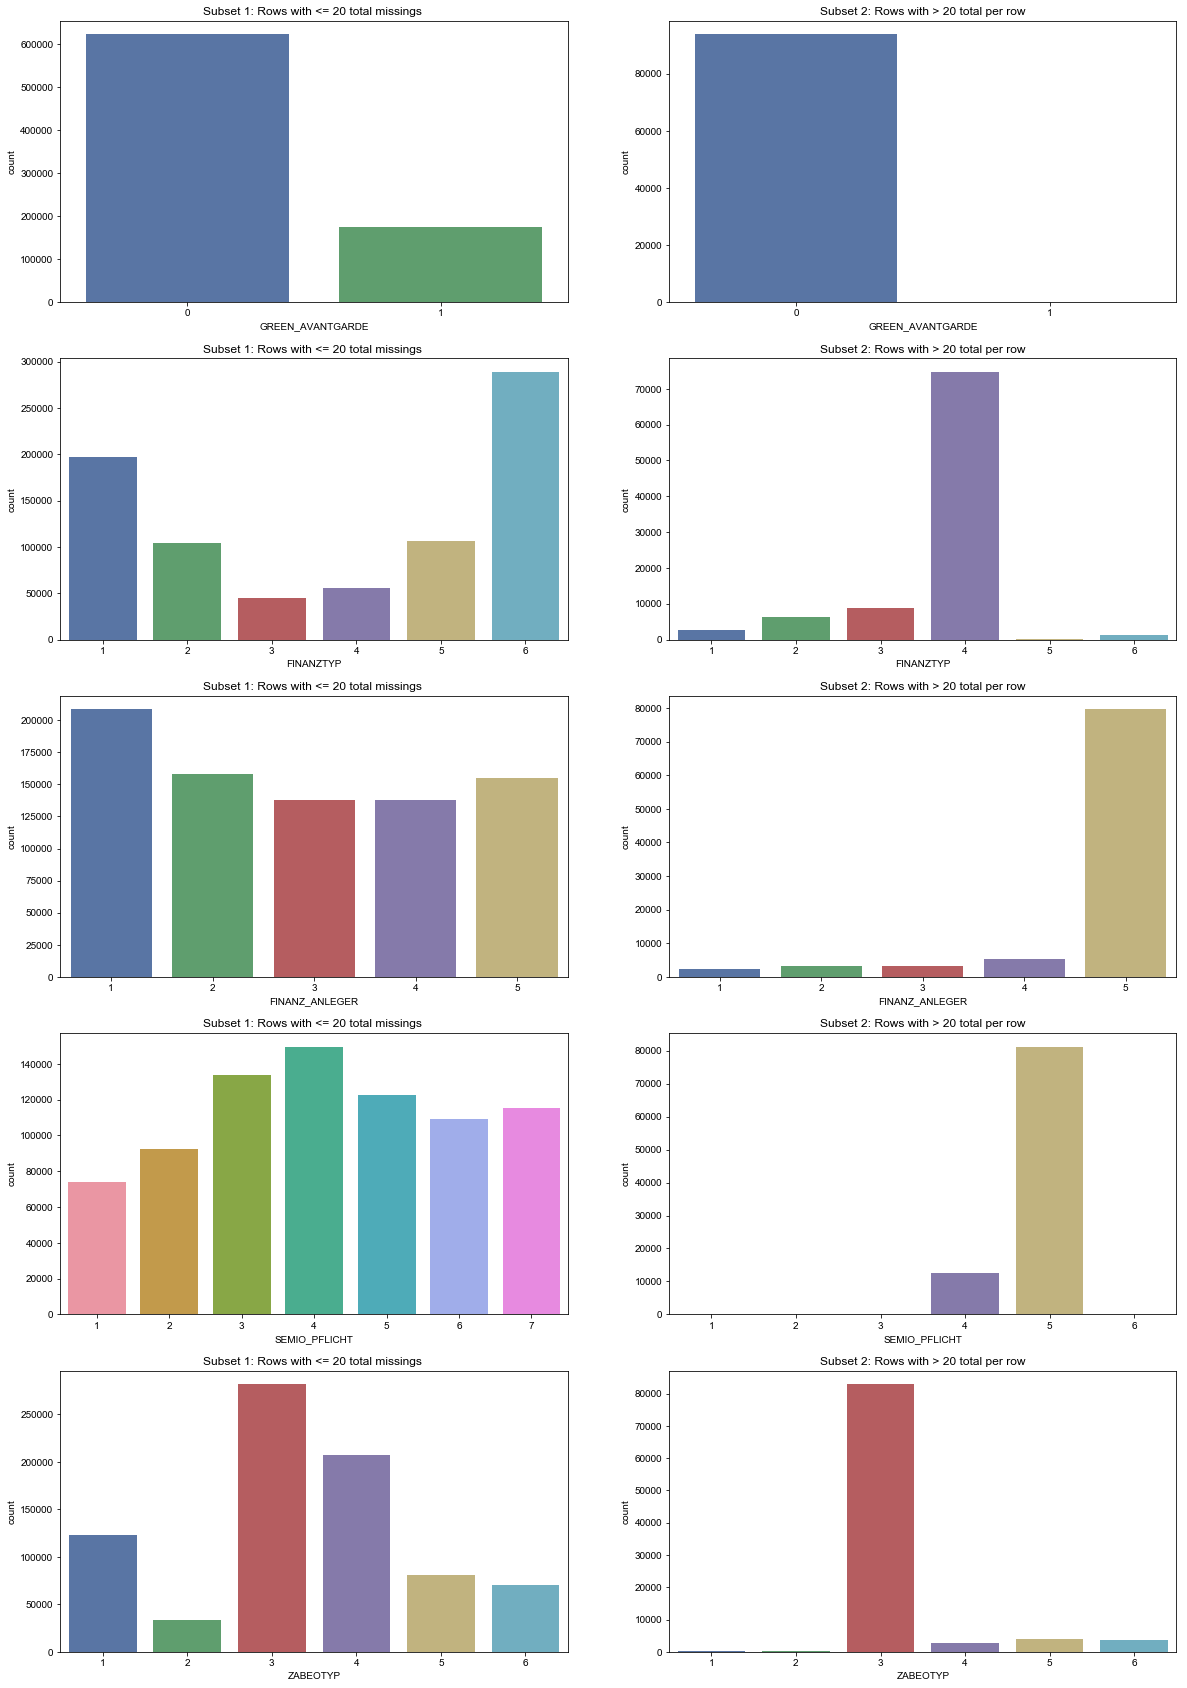

In [25]:
# Plot both subsets for five features side by side
# differences in distribution?
fig, axes = plt.subplots(nrows= 5, ncols = 2, figsize = (20,30))
n = 0

sns.set(style="darkgrid")

for column in five_cols:
    sns.countplot(sub1.loc[:, column], ax = axes[n,0])
    axes[n,0].set_title("Subset 1: Rows with <= 20 total missings ")
    sns.countplot(sub2.loc[:, column], ax = axes[n,1])
    axes[n,1].set_title("Subset 2: Rows with > 20 total per row")
    n+=1

####  Assess Missing Data in Each Row
After deleting the outlier columns we have on average 5.7 missing values per row. Moreover, the 0.5 quantile (median) as well as the 0.65 quantile is zero. Hence, 65% of the rows have zero missings. Additionally, even the 0.85 Quantile is only 8, which means that 85% of the rows have 8 or fewer missings.

We have 719,624 rows (80.75%) with fewer or equal to 5 missings and 171,597 rows (19.25%) have more than 5 missings. 

The histogram implies that there are many rows with zero or close to zero missing values. Moreover, (almost) no rows with 20 - 30 missing values before the number of rows with 30 or more missing values per rows are increasing again.

In addition it seems as there is a gap betwen 20 and 30 missing values per row as almost 90% of rows have fewer than 20 missing values.

Function subset_row_missings divides the dataset into a subset 1 with fewer or equal to the determined values of missings per row and one subset which consists of the rows with more than the determined value of missings. 

The task is now to create a subset based on no or few missing values. I have determined this threshold to be five missing values per row. Afterwards I have plotted both subsets for five cols to see differences in distribution.

Col. 1 ("GREEN AVANTGARDE"): Of those with fewer than 20 missing values per row roughly 180,000 are of type 1 in subset 1, whereas in subset 2 virtually nobody is of type 1

Col. 2 ("FINANZTYP"): Distribution between both subsets is pretty different here as well. Whereas the most common type in subset 1 is `6`, most of the individuals in subset 2 belong to group 4. 

Col. 3 ("FINANZ_ANLEGER"): Whereas the distribution of individuals in subset 1 (<= 20 missings) is roughly uniform for groups 2 to 5 and most individuals belong to group 1, most individuals in subset 2 belong exclusively to category 5. 

Col. 4 ("SEMIO_Pflicht"): Again we see a quite different distribution between both subsets. In subset 1 individuals are spread across many groups, in particular group 3-7. In stark contrast individuals of subset 2 belong only to group 5 and few to group 4.

Col. 5 ("ZABEOTYP"): For this feature we see that in both subsets the most common category is no.5. However, whereas individuals of subset 2 almost exclusively belong to this group, it is more heterogeneous for subset 1.   

To summarize, data with >20 missing values per row seem to be qualitatively very different from data with <= 20 missing values per row.

In general, the problem of missing data is the additional noise we would include in the analysis making it harder to squeeze out the underlying signal. I have decided to continue the analysis using only the data of subset1 (`sub1`) from here. It may be interesting to compare both subsets in a later stage of the analysis to compare differences and the causal basis of why they are so different but this is beyond the scope of this version of the project.

### Select and Re-Encode Features
Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, we make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

We will now perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether to keep, drop, or re-encode. Then, we will create a new data frame with only the selected and engineered columns.

Data wrangling is often tricky and there's a lot of it to be done here. But once we're done with this step, we'll be ready to get to the more satisfying parts of modeling the data and squeezing out some of their secrets. 

In [26]:
# How many features are there of each data type?
feat_info.groupby("type").count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Re-Encode Categorical Features

For categorical data, we would normally need to encode the levels as dummy variables. Depending on the number of categories however, we perform one of the following:

- For binary (two-level) categoricals that take numeric values, we keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to simplify things) just drop them from the analysis if appropriate. 

**Assess categorical variables:** Which are binary, which are multi-level? Which one needs to be re-encoded?

In [27]:
# Change to array
feat_info_categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].values
feat_info_categorical = [x for x in feat_info_categorical if x in azdias.columns]

# Results in categorical features of the reduced dataset
print("We have", len(feat_info_categorical), "categorical variables.")

We have 18 categorical variables.


In [28]:
# List of binary variables
binary = [x for x in feat_info_categorical if azdias[x].nunique()==2]
azdias[binary][:5]

# How many...
print("We have", len(binary), "binary variables.")

We have 5 binary variables.


In [29]:
# List of multilevel variables
multilevel = [x for x in feat_info_categorical if azdias[x].nunique()>2]
azdias[multilevel][:5]

# How many ...
print("We have", len(multilevel), "multilevel variables.")

We have 13 multilevel variables.


**Next step:** Taking a closer look at categorical variables to see of how many categories they are comprised. Note that for each category we have to add K-1 dummy variables. For example: `ANREDE_KZ` consists of two categories. We need only one 0/1 dummy variable to express this in vectorized form.

In [30]:
# Uncomment to take a look at categorical data to decide on how to proceed
# azdias[feat_info_categorical][:5]

# And another look on how many categories we have per feature...
azdias[feat_info_categorical].nunique()

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

**Notes**  
We see that most of the categorical variables have fewer than 7 different categories which is fine to apply one-hot encoding (adding dummy variables). But there are three variables with 10, 11, and 12 categories respectively, which I will drop for the following reasons: 
- They result in too many dummies which may lead to computational performance issues later on.
- Moreover, for `STATUS` and `FAMILIE` there are close substitutes constituting of nearly the same informational content in a broader coding.

In addition, there is one variable that stands out, namely "CAMEO_DEU_2015" which has 44 factors and encodings like "8A, 4C, 6B", etc. I decided to drop this variable and not construct 44 dummies for this variable. 

In addition, the variable `OST_WEST_KZ` is decoded as "W" and "O" (in german "Osten" for 'east' and "Westen" for 'west'). We simply re-encode this to "W" as 0 and "O" to 1. 

In [31]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Drop variables as stated above
col_remove = ["CAMEO_DEU_2015", "GFK_URLAUBERTYP", 
              "LP_FAMILIE_FEIN", "LP_STATUS_FEIN"]

# Remove specified columns in place (don't run this more than once...)
for col in col_remove:
    multilevel.remove(col)
    sub1.drop(col, axis = 1, inplace=True)

sub1.shape

(797426, 75)

In [32]:
# Mapping of W -> 0 and O -> 1
sub1["OST_WEST_KZ"] = sub1["OST_WEST_KZ"].map({"W": 0, "O": 1})
sub1[:5]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [33]:
# Check if two values are left
sub1["OST_WEST_KZ"].nunique()

2

**Next:** Re-Encode the other categorical variables

In [34]:
# Using pd.get_dummies for one-hot encoding
for col in multilevel:
    df = sub1[col][sub1[col].notnull()]
    sub1 = sub1.join(pd.get_dummies(df, prefix=col))
    sub1.drop([col], axis = 1, inplace=True)

In [35]:
# Check the new shape of our data
print("New shape:", sub1.shape[0], "rows and", sub1.shape[1], "features/variables.") 

New shape: 797426 rows and 117 features/variables.


#### Recap: Re-Encode Categorical Features
- Of 21 initial categorical variables, 18 remain to be taken care of ("special handling").
- `CAMEO_DEU_2015` and three other variables were dropped. 
- `OST_WEST_KZ` was re-encoded from "W"/"O" to O/1.
- New shape of the data seems plausible.

#### Engineer Mixed-Type Features
There are some features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:

- `PRAEGENDE_JUGENDJAHRE` combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- `CAMEO_INTL_2015` combines information on two axes: wealth and life stage. We break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

Note that the respective coding is clarified in the accompanying code book which I am not allowed to share. However, I think that the individual steps become clearer as we move along and apply them to the data.  

In [36]:
# Table of mixed type variables from feat_info
feat_info_mixed = feat_info[feat_info["type"] == "mixed"]

# Get mixed variable names 
mixed_array = feat_info_mixed["attribute"].values

# List of mixed cols we want to keep
mixed = [x for x in mixed_array if x in sub1.columns]

# Show what we did...
print(feat_info_mixed.head(), "\n\n",mixed_array, "\n\n", mixed)

                attribute information_level   type missing_or_unknown
15    LP_LEBENSPHASE_FEIN            person  mixed                [0]
16    LP_LEBENSPHASE_GROB            person  mixed                [0]
22  PRAEGENDE_JUGENDJAHRE            person  mixed            [-1, 0]
56               WOHNLAGE          building  mixed               [-1]
59        CAMEO_INTL_2015     microcell_rr4  mixed           [-1, XX] 

 ['LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'PRAEGENDE_JUGENDJAHRE'
 'WOHNLAGE' 'CAMEO_INTL_2015' 'KBA05_BAUMAX' 'PLZ8_BAUMAX'] 

 ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


Now we will investigate the variable `PRAEGENDE_JUGENDJAHRE` and engineer two new variables. From the data dictionary (or code book) we know the encoding of the variable that indicates `mainstream` or `avantgarde`. We engineer a new variable to capture this.  

In [37]:
# Have a look at the variable
sub1["PRAEGENDE_JUGENDJAHRE"][:5]

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [38]:
# Mainstream / Avantgarde coding is taken from the data dictionary
ms, av = [1,3,4,8,10,12,14], [2,4,6,7,9,11,13,15]

In [39]:
# Function to disentangle 
def disentangler(x):
    """
    Input is variable of 'PRAEGENDE_JUGENDJAHRE'
    Results in 1 if value is in the list ms and 0 otherwise.
    """
    if x in ms: 
        res = 1
    elif x in av:
        res = 0
    else:
        res = x
    return res

In [40]:
# Create new variable indicating whether mainstream=1 or avantgarde =0
sub1["PRAEGENDE_JUGENDJAHRE_MS"] = sub1["PRAEGENDE_JUGENDJAHRE"].apply(disentangler)

In [41]:
sub1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MS
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


We create another variable which indicates the respective decade.

In [42]:
#### Create 2nd variable 
# Start with the mapping
x, y = [x+1 for x in range(15)], [40,40,50,50,60,60,60,70,70,80,80,80,80,90,90]
dec = pd.Series(y, x)

# Engineer decade variable by applying the mapping
sub1["PRAEGENDE_JUGENDJAHRE_DEC"] = sub1["PRAEGENDE_JUGENDJAHRE"].map(dec)

# Show decade variable
sub1["PRAEGENDE_JUGENDJAHRE_DEC"][:7]

1    90.0
2    90.0
3    70.0
4    70.0
5    50.0
6    80.0
7    70.0
Name: PRAEGENDE_JUGENDJAHRE_DEC, dtype: float64

In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
sub1["CAMEO_INTL_2015"][:7]

1    51
2    24
3    12
4    43
5    54
6    22
7    14
Name: CAMEO_INTL_2015, dtype: object

In [44]:
# Engineer first variable
sub1.loc[sub1['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_WEALTH'] = sub1.loc[sub1['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[0]))

# Show variable
sub1["CAMEO_INTL_2015_WEALTH"][:7]

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
6    2.0
7    1.0
Name: CAMEO_INTL_2015_WEALTH, dtype: float64

In [45]:
# Engineer second variable
sub1.loc[sub1['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_LIFESTAGE'] = sub1.loc[sub1['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[1]))

# Show second variable after reengineering
sub1['CAMEO_INTL_2015_LIFESTAGE'][:7]

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
6    2.0
7    4.0
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: float64

We are now going to drop the initial variables and the rest of the mixed variables which we don't need anymore. In principle we could add additional re-engineered variables but again, we keep it simple for now... 

In [46]:
# Show all pristine mixed variables
print(mixed)

# Drop all un-engineered mixed variables
sub1.drop(mixed, axis=1, inplace=True)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [47]:
# Show what's left...
sub1[:7]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MS,PRAEGENDE_JUGENDJAHRE_DEC,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,90.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,70.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,70.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,50.0,5.0,4.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,80.0,2.0,2.0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,70.0,1.0,4.0


In [48]:
# New shape
print("New shape:", sub1.shape)

New shape: (797426, 115)


#### Summary: Engineer Mixed-Type Features
- Disentangled (or re-encoded) the variable `PRAEGENDE_JUGENDJAHRE` into mainstream (ms) and avantgarde (av) based on coding in data dictionary to a binary variable `PRAEGENDE_JUGENDJAHRE_MS`.
- Re-engineered a variable that indciates the decade. 
- Re-engineered `CAMEO_INTL_2015` to a variable for wealth and one for the respective lifestage 
- Dropped the initial variables that we used for engineering new variables
- Dropped `LP_LEBENSPHASE_FEIN` as it consists of almost the same information as `LP_LEBENSPHASE_GROB` and has too many levels.

#### Complete Feature Selection

In order to finish this step, we need to make sure that the data frame only consists of the columns that we want to keep. The dataframe should now consist of:

- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

### Create a Cleaning Function
We have to redo all the cleaning and engineering steps on the customer dataset (we only worked with general demographic data so far) and probably repeat this task again in the futre. Hence,  we'd like to automate this using a function that does all the previous steps for us. This is what we are going to do now:

In [49]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    for index in feat_info.index:
        feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
        for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
            try:
                feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
            except:
                continue
        df.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)        
    
    # Drop cols (outlier cols) + "GEBAUEDTYP" (issues with dummies)
    drop_col = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX', "GEBAEUDETYP"]
    df.drop(drop_col , axis=1, inplace=True)
    
    # Index for rows with missings of equal or fewer than 20
    row_missings = df.isnull().sum(axis=1)
    idx1 = row_missings.index[row_missings <= 20]
    idx2 = row_missings.index[row_missings > 20]
    
    categorical = feat_info[feat_info["type"] == "categorical"]["attribute"].values
    categorical = [x for x in categorical if x in df.columns]
    binary = [x for x in categorical if df[x].nunique()==2]
    multilevel = [x for x in categorical if df[x].nunique()>2]
    
    col_remove = ["CAMEO_DEU_2015", "GFK_URLAUBERTYP", 
              "LP_FAMILIE_FEIN", "LP_STATUS_FEIN"]

    for col in col_remove:
        multilevel.remove(col)
        df.drop(col, axis = 1, inplace=True)

    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].map({"W": 0, "O": 1})
    
    for col in multilevel:
        dat = df[col][df[col].notnull()]
        df = df.join(pd.get_dummies(dat, prefix=col))
        df.drop([col], axis=1, inplace=True)
    
    mixed = feat_info[feat_info['type'] == 'mixed']['attribute'].values
    mixed = [x for x in mixed if x in df.columns] 
        
    ms = [1,3,4,8,10,12,14]
    av = [2,4,6,7,9,11,13,15]
    df['PRAEGENDE_JUGENDJAHRE_MS'] = df['PRAEGENDE_JUGENDJAHRE'].apply(disentangler)
      
    x = [x+1 for x in range(15)]
    y = [40,40,50,50,60,60,60,70,70,80,80,80,80,90,90]
    dec = pd.Series(y, index = x)
    df['PRAEGENDE_JUGENDJAHRE_DEC'] = df['PRAEGENDE_JUGENDJAHRE'].map(dec)
    
    df.loc[df['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_WEALTH'] = df.loc[df['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[0]))
    df.loc[df['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015_LIFESTAGE'] = df.loc[df['CAMEO_INTL_2015'].notnull(),'CAMEO_INTL_2015'].map(lambda x:int(str(x)[1]))

    df.drop(mixed, axis=1, inplace=True)
    
    clean_df = df.loc[idx1]
    dirty_df = df.loc[idx2]  
        
    # Return clean and dirty dataframe.
    return clean_df, dirty_df

**Notes**  
Applying one-hot encoding to the variable "GEBAEUDETYP" causes some issues as there are no values for one of the dummy variables (no dummy for `GEBAEUDETYP_5.0`) leading to a different number of features for both datasets. This would become a problem later on. 

Again, there are other ways to solve this but the easiest one for now is to drop this variable entirely.

#### Checking the function
We are checking whether the function seems to work or not. Note that applying the function may take a while...

In [50]:
# Reload the initial data and check if the function worked
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

# Reload and check if the function worked
import time
start = time.time()
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")
clean_azdias, dirty_azdias = clean_data(azdias)
end = time.time()
print(end - start)

53.536141872406006


In [51]:
# Load customers data to check if we have same numbers of cols, etc.
start = time.time()
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")
clean_customers, dirty_customers = clean_data(customers)
end = time.time()
print(end - start)

9.093443870544434


Same shape for both cleaned datasets?

In [52]:
# Shape of clean azdias 
print(clean_azdias.shape)

# Shape of clean customers data
print(clean_customers.shape)

# Change notation to initial one / simplify notation
# Aliasing so data is not copied and drains RAM
sub1 = clean_azdias
customers = clean_customers

(797426, 108)
(141640, 108)


---
## Part 2: Feature Transformation and Principal Component Analysis

### Apply Feature Scaling

Before we apply dimensionality reduction to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, we'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html).

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to the data, we make sure that the DataFrame is cleaned of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values.

- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.

- For these classes, we can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. 

Note that later we'll applying the fitted objects again to the customer demographics data. It is important that we do not fit them again in order to have a consistent scaling.

In [53]:
# Initialize instance of the class...
imputer = Imputer()
sub1 = pd.DataFrame(imputer.fit_transform(sub1), columns = sub1.columns)

# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
sub1 = pd.DataFrame(scaler.fit_transform(sub1), columns = sub1.columns)

### Perform Dimensionality Reduction
We can now apply dimensionality reduction techniques to the data using the skelarn library.

- [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis (PCA) on the data, thus finding the vectors of maximal variance in the data.

- We check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Afterwards, we plot the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. 

- Based on the findings, we select a value for the number of transformed features we'll retain for the clustering part of the project.

In [54]:
# Initialize an instance of PCA() class and fit to sub1
pca = PCA()
sub1_pca = pca.fit_transform(sub1)

# Show cumulative sum of explained variance ratio
np.cumsum(pca.explained_variance_ratio_)[:50]

array([0.12151871, 0.21882256, 0.28027692, 0.31648147, 0.34375323,
       0.36555191, 0.38541812, 0.40510349, 0.42336413, 0.44102372,
       0.45800588, 0.47376023, 0.4885777 , 0.50286147, 0.51631735,
       0.52936753, 0.54211465, 0.55430394, 0.56640831, 0.57847996,
       0.59005957, 0.60141934, 0.61259071, 0.62361846, 0.63456035,
       0.64539643, 0.65592829, 0.66640222, 0.676737  , 0.68690422,
       0.69703054, 0.70689993, 0.71674038, 0.72647349, 0.73608417,
       0.74555012, 0.75497633, 0.76419137, 0.77318761, 0.78213186,
       0.79100514, 0.79958539, 0.80812077, 0.81642414, 0.8243143 ,
       0.8320925 , 0.83963406, 0.84705163, 0.85414269, 0.86100243])

**Notes**  
From above we see that we need 5 principal components to explain more than a third of the variance, 14 to explain half of it and around 43 principal components to get to a cum. variance of more than eighty percent.

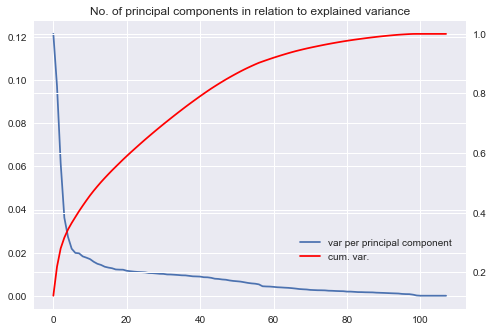

In [55]:
# Visual investigation of the variance accounted for by each PC.
fig = plt.figure()
ax = fig.add_axes([0,0,1,1],True)
ax.set_title("No. of principal components in relation to explained variance")
ax2 = ax.twinx()
ax.plot(pca.explained_variance_ratio_, label='var per principal component',)
ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='cum. var.',color = 'red');
fig.legend(loc=(0.6,0.2));

**Notes**  
Fewer than 15 principal components are needed to achieve an explained cumulative variance of 50%. Moreover, with little more than 40 principal components, 80% of variance can be explained.

In [56]:
# Re-apply PCA to the data while selecting number of components to retain.
n = 43
pca = PCA(n_components = n, random_state=42)
sub1_pca = pca.fit_transform(sub1)
pca_expl = pca.explained_variance_ratio_.sum()
print("Explained variance using {} components is: {:.2f}%".format(n,pca_expl*100))

Explained variance using 43 components is: 80.72%


### Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some way.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we have to map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component will be those at the beginning and end of the sorted list. 

- The data dictionary document helps to understand these prominent features, their relationships, and what a positive or negative value on the principal component might indicate.

- We investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, we write a function that can be called at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when we interpret the tendencies of the discovered clusters.

In [57]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def pca_fun(data):
    feat = pd.Series(data.columns, range(len(data.columns)))
    comp = {}
    for i in range(pca.components_.shape[0]):
        comp[i] = [(feat[a],b) for a,b in sorted(enumerate(pca.components_[i]),key=lambda x:x[1],reverse=True)]
    return pd.DataFrame(comp)

comp = pca_fun(sub1)

# show comp
comp.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,"(LP_STATUS_GROB_1.0, 0.20325682404854287)","(ALTERSKATEGORIE_GROB, 0.22593231638214462)","(SEMIO_VERT, 0.32673630623661826)","(GREEN_AVANTGARDE, 0.33091059594549815)","(ANZ_PERSONEN, 0.2977204106348195)","(KBA13_ANZAHL_PKW, 0.3523187023959497)","(KBA05_ANTG4, 0.2591319926995533)","(KBA05_ANTG4, 0.322598275090719)","(NATIONALITAET_KZ_2.0, 0.2686736867034312)","(REGIOTYP, 0.25074381139268104)",...,"(SOHO_KZ, 0.5226296052653983)","(LP_FAMILIE_GROB_4.0, 0.46972136226501665)","(NATIONALITAET_KZ_3.0, 0.3497744937855006)","(CAMEO_DEUG_2015_5, 0.4590212646082588)","(WOHNDAUER_2008, 0.3351077071984484)","(ANZ_HH_TITEL, 0.4625877228619181)","(KBA05_ANTG3, 0.2244070699396672)","(ZABEOTYP_4, 0.35551836554504584)","(ZABEOTYP_6, 0.3455294127870479)","(SOHO_KZ, 0.46163872600346895)"
1,"(PLZ8_ANTG3, 0.1940853944894831)","(FINANZ_VORSORGER, 0.21164474876951095)","(SEMIO_FAM, 0.25806916245786454)","(LP_STATUS_GROB_5.0, 0.2709454115787222)","(LP_FAMILIE_GROB_5.0, 0.24682251166267688)","(PLZ8_HHZ, 0.32044547149326974)","(ANZ_HAUSHALTE_AKTIV, 0.23622342044671607)","(ANZ_HAUSHALTE_AKTIV, 0.25883032156312946)","(NATIONALITAET_KZ_3.0, 0.2180751538268724)","(KKK, 0.22910593697149811)",...,"(ZABEOTYP_2, 0.2669086540635914)","(CAMEO_DEUG_2015_9, 0.2568052271993823)","(SOHO_KZ, 0.34313693162408115)","(NATIONALITAET_KZ_3.0, 0.44660815300312906)","(FINANZTYP_4, 0.2701594311702839)","(SOHO_KZ, 0.23895922806647726)","(CAMEO_DEUG_2015_7, 0.2193797482910828)","(ANZ_HH_TITEL, 0.17181027323497527)","(SHOPPER_TYP_0.0, 0.3128539126792891)","(ZABEOTYP_1, 0.3771617626757052)"
2,"(CAMEO_INTL_2015_WEALTH, 0.189239983742159)","(ZABEOTYP_3, 0.20513983484792153)","(SEMIO_SOZ, 0.25771199206886286)","(EWDICHTE, 0.25742520422589416)","(KKK, 0.23386282969744016)","(ANZ_PERSONEN, 0.27700729381257394)","(SHOPPER_TYP_3.0, 0.20617550152865918)","(KBA13_ANZAHL_PKW, 0.2523954528693729)","(SEMIO_TRADV, 0.20398286655066336)","(NATIONALITAET_KZ_2.0, 0.17431431155409532)",...,"(NATIONALITAET_KZ_2.0, 0.21246157500329693)","(CAMEO_DEUG_2015_2, 0.22127372204477966)","(LP_FAMILIE_GROB_3.0, 0.3198893580744107)","(SOHO_KZ, 0.35495854977682995)","(LP_FAMILIE_GROB_3.0, 0.21315238396505196)","(KBA05_ANTG2, 0.22250896208024393)","(FINANZTYP_4, 0.21899299510614093)","(LP_FAMILIE_GROB_5.0, 0.16697777434977004)","(FINANZTYP_4, 0.2101185926091189)","(RELAT_AB, 0.168150683070761)"
3,"(HH_EINKOMMEN_SCORE, 0.18892347561650039)","(SEMIO_ERL, 0.1882739971415195)","(SEMIO_KULT, 0.24690570140768683)","(ORTSGR_KLS9, 0.24689860233994168)","(FINANZTYP_6, 0.22564245822739656)","(PLZ8_GBZ, 0.25934689093506497)","(ANZ_HH_TITEL, 0.1834505544283084)","(PLZ8_HHZ, 0.24560740357305635)","(ZABEOTYP_6, 0.19613110759525884)","(FINANZTYP_2, 0.16775860673539375)",...,"(CJT_GESAMTTYP_1.0, 0.16850523710152782)","(CJT_GESAMTTYP_4.0, 0.1853259678873041)","(CAMEO_DEUG_2015_4, 0.19380739570705782)","(LP_FAMILIE_GROB_4.0, 0.1833861372151892)","(ANZ_HH_TITEL, 0.20977670527582556)","(ANZ_HAUSHALTE_AKTIV, 0.21968566478097726)","(CAMEO_DEUG_2015_4, 0.21074121586855446)","(NATIONALITAET_KZ_3.0, 0.1336636290788706)","(ZABEOTYP_4, 0.18756935338799502)","(KBA05_ANTG3, 0.15440845336706976)"
4,"(PLZ8_ANTG4, 0.18742668010881347)","(SEMIO_LUST, 0.16021868841839781)","(FINANZTYP_5, 0.13684732568598618)","(ANZ_PERSONEN, 0.14996499482980302)","(OST_WEST_KZ, 0.18836506766598765)","(LP_FAMILIE_GROB_5.0, 0.25455442365206443)","(FINANZ_HAUSBAUER, 0.1798509703199863)","(MIN_GEBAEUDEJAHR, 0.18879062805454763)","(SEMIO_RAT, 0.19560525292149097)","(KBA05_ANTG4, 0.15530770541938552)",...,"(CAMEO_DEUG_2015_9, 0.14642884039855886)","(CAMEO_DEUG_2015_3, 0.17030349286147017)","(CAMEO_DEUG_2015_2, 0.1313010892481541)","(LP_STATUS_GROB_1.0, 0.10622479981685373)","(CJT_GESAMTTYP_1.0, 0.17822175566984985)","(LP_STATUS_GROB_2.0, 0.16742952168783576)","(NATIONALITAET_KZ_2.0, 0.17353198866424366)","(SHOPPER_TYP_2.0, 0.13259280789749953)","(FINANZTYP_3, 0.17873010782570123)","(GEBAEUDETYP_RASTER, 0.1265727

### First principal component
Map weights for the first principal components to corresponding feature names and then print the linked values, sorted by weight.

In [58]:
# Show first 5 of principal component 1
comp[:5][0]

0      (LP_STATUS_GROB_1.0, 0.20325682404854287)
1               (PLZ8_ANTG3, 0.1940853944894831)
2    (CAMEO_INTL_2015_WEALTH, 0.189239983742159)
3      (HH_EINKOMMEN_SCORE, 0.18892347561650039)
4              (PLZ8_ANTG4, 0.18742668010881347)
Name: 0, dtype: object

In [59]:
comp[-5:][0]

103             (KBA05_GBZ, -0.1895778379620755)
104           (PLZ8_ANTG1, -0.19354755227237752)
105          (KBA05_ANTG1, -0.19919050593814505)
106    (FINANZ_MINIMALIST, -0.21209822195362804)
107           (MOBI_REGIO, -0.21305614855711275)
Name: 0, dtype: object

### Second principal component
Same for the second principal component

In [60]:
# 2nd PC, first five
comp[:5][1]

0    (ALTERSKATEGORIE_GROB, 0.22593231638214462)
1        (FINANZ_VORSORGER, 0.21164474876951095)
2              (ZABEOTYP_3, 0.20513983484792153)
3                (SEMIO_ERL, 0.1882739971415195)
4              (SEMIO_LUST, 0.16021868841839781)
Name: 1, dtype: object

In [61]:
# 2nd PC, last five
comp[-5:][1]

103                  (SEMIO_TRADV, -0.20509023585708952)
104         (FINANZ_UNAUFFAELLIGER, -0.2111877179028752)
105                (FINANZ_SPARER, -0.21121331706292812)
106                    (SEMIO_REL, -0.21184774153733715)
107    (PRAEGENDE_JUGENDJAHRE_DEC, -0.23005036693804043)
Name: 1, dtype: object

### Third principal component

In [62]:
# 3rd PC, first five
comp[:5][2]

0     (SEMIO_VERT, 0.32673630623661826)
1      (SEMIO_FAM, 0.25806916245786454)
2      (SEMIO_SOZ, 0.25771199206886286)
3     (SEMIO_KULT, 0.24690570140768683)
4    (FINANZTYP_5, 0.13684732568598618)
Name: 2, dtype: object

In [63]:
# 3rd PC, last five
comp[-5:][2]

103      (SEMIO_ERL, -0.1967329057789234)
104    (SEMIO_KRIT, -0.27069687845665946)
105       (SEMIO_DOM, -0.299995472488797)
106     (SEMIO_KAEM, -0.3265228025062786)
107      (ANREDE_KZ, -0.3541708473993428)
Name: 2, dtype: object

### Interpretation Principal Components
**First principal component:**  
High correlation and therefore important contribution in explaining the variation have the factors:
- Status
- Income
- Living conditions (especially living in regions where bigger apartment buildings seem more prevaent)
- Wealth 
- Size of community.

**Second principal component:**  
Dimensions of this principal component are to a large extent determined by:
- Age
- Financial literacy
- Personal attitudes (especially dutifulness, traditional and religious)

**Third principal component:**  
This principal components direction is in large part explained by:
- Personality typology: 
 - Positive: Dreamfulness, family-, socially-, and cultural mindfulness
 - Negative: Rational, event-orientede, critical-minded or combative classified individuals
- Gender is negataively associated with this component

It can be noted that in PCA the factor loading is the correlation of the variable on the respective PC. Therefore negative **and** positive values are both important. The higher the number the further away from the midpoint and, thus,  the more important they are for the principal component.

## Part 3: Clustering

### Apply Clustering to General Population
So far, we have assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time so see how the data clusters in the principal components space. We will apply k-means clusering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- We will use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.

- Then, we compute the average difference from each point to its assigned cluster's center. The KMeans object's `.score()` method seems to be useful here. In sklearn, scores tend to be defined so that larger is better.
- We perform the above two steps for a number of different cluster counts to see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. We use this fact to select a final number of clusters in which to group the data.
- We'll plot the score and look out whether we can use the so-called [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)).
- Because of the large size of the dataset, it takes a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take.
- Once we've selected a final number of clusters to use, we re-fit a KMeans instance to perform the clustering operation. We will also obtain the cluster assignments for the general demographics data to use them later for comparison.

After realizing that my computer takes a lot of time for fitting many `KMeans()` instances, I have opted to use the `MiniBatchKmeans()` class to determine the optimal no. of clusters before using `KMeans()` on the perceived, optimal number of classes. Feel free to deviate from my approach.

In [64]:
# Determine list of cluster nums
cluster_nums = list(range(1,26))

# Lists to keep track of results
distances = []
score = []

# Run MiniBatchKMeans clustering on the data using different numbers of clusters
# For-loop to perform the tasks, collect and print results
for c in cluster_nums:  

    kmeans = MiniBatchKMeans(c)
    preds = kmeans.fit_predict(sub1_pca)
    
    # compute average within-cluster distances.
    pred_centroids = kmeans.cluster_centers_
    centers = pred_centroids[preds]
    distance = np.sqrt(((sub1_pca - centers) ** 2).sum(axis=1)).mean()
    distances.append(distance)
    
    # Score 
    sc = kmeans.score(sub1_pca)
    score.append(sc)
    
    print("Evaluation: {} clusters | Distance:{:.4f} | Score: {:.4f}".format(c, distance, sc))

Evaluation: 1 clusters | Distance:9.2338 | Score: -69560908.5770
Evaluation: 2 clusters | Distance:8.6881 | Score: -61848565.3402
Evaluation: 3 clusters | Distance:8.3643 | Score: -57423170.8407
Evaluation: 4 clusters | Distance:8.1956 | Score: -55086598.9088
Evaluation: 5 clusters | Distance:8.0710 | Score: -53531137.7301
Evaluation: 6 clusters | Distance:8.0470 | Score: -53311177.3120
Evaluation: 7 clusters | Distance:7.9256 | Score: -51718115.8033
Evaluation: 8 clusters | Distance:7.7820 | Score: -49955390.3373
Evaluation: 9 clusters | Distance:7.8263 | Score: -50521025.1126
Evaluation: 10 clusters | Distance:7.8087 | Score: -50287613.4948
Evaluation: 11 clusters | Distance:7.7108 | Score: -49081505.8934
Evaluation: 12 clusters | Distance:7.6059 | Score: -47431498.5978
Evaluation: 13 clusters | Distance:7.6399 | Score: -48179610.2636
Evaluation: 14 clusters | Distance:7.5078 | Score: -46362478.5264
Evaluation: 15 clusters | Distance:7.5918 | Score: -47607595.4178
Evaluation: 16 clus

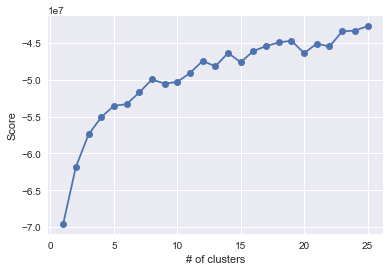

In [65]:
# Plot score vs. no. of clusters. Elbow?
plt.plot(cluster_nums, score, '-o');
plt.ylabel("Score")
plt.xlabel("# of clusters");

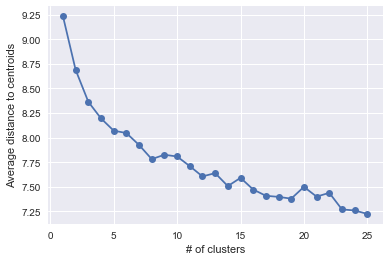

In [66]:
# Same for distances
plt.plot(cluster_nums, distances, '-o');
plt.ylabel("Average distance to centroids")
plt.xlabel("# of clusters");

**Notes:**  
It seems that after 10, 11 clusters the change in score/average distance to centroids is only marginal. Hence, this seems to be a good number of Clusters. Next, we'll fit an instance of the `KMeans()` class to 11 Clusters. 

In [67]:
# Re-fit the k-means model with the selected number of clusters and obtain
#cluster predictions for the general population demographics data.
kmeans = KMeans(11, random_state=42)
clusters_pop = kmeans.fit_predict(sub1_pca)

### Summary: Apply Clustering to General Population
Due to performance issues with `KMeans()`, I haven chosen `MiniBatchKmeans()` to determine the number of clusters. In order to do this I plotted the score as well as the avearge distance to centroids. After a rapid increase (plot1), respectively decrease (plot2) after 7 clusters it seems as for both plots the change seems to be rather small. In particular after 10-15 clusters there is not much change here. Hence, following the elbow method, one should choose between 10-15 clusters. As there seems to be a small uptick after 11 clusters, this seems to be a reasonable number of clusters. 

### Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Instead of re-fitting, we're going to use the fits from the general population to clean, transform, and cluster the customer data. Hence we get the same cleaning, transformations, scaling and clusters for the new data. In the last step of the project, we will interpret how the general population fits apply to the customer data.

- We apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function created earlier.

- Also, we use the same sklearn objects from the general demographics data, and apply their transformations to the customers data. Hence, we must not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should we create/instantiate new sklearn objects! We will carefully carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

#### Did I mention that it is of paramount importance to not change the objects or fit in the following? 

In [68]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Load in customer demographics data, if not done before
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter =";")

# Apply cleaning function
customers, dirty_customers = clean_data(customers)

# Impute
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

# Scale
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

# PCA
customers_pca = pca.transform(customers)

# KMeans
clusters_customers = kmeans.predict(customers_pca)

In [69]:
# Checking the shape
print("Shape transformed, scaled customer data:", customers.shape)

# Show head of scaled and transformed data
print("\n",customers.head())

# Check if we have 43 principal components
print("Shape PCA:",customers_pca.shape)

# Check if each individual is associated with one cluster
print("\nClusters of the first 20 individuals:",clusters_customers[:20])

Shape transformed, scaled customer data: (141640, 108)

    ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0              1.184837  -1.043765           1.409069      -1.155304   
1              1.184837   0.958071           1.409069      -1.155304   
2              1.184837  -1.043765           1.409069      -1.155304   
3              0.201306  -1.043765          -0.042770      -1.155304   
4              0.201306  -1.043765           1.409069      -1.155304   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0          1.137960       -1.249881              -0.469752         -0.792034   
1          1.137960       -1.249881               0.959677          0.628533   
2          1.137960       -0.570799              -1.184467         -0.792034   
3          0.411731        0.787366               1.674391         -0.792034   
4          1.137960       -1.249881              -0.469752         -0.081750   

   GREEN_AVANTGARDE  HEALTH_T

### Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In the final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. 

If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

We will perform the following steps:

- Calculating the proportion of data points in each cluster for the general population and the customer data. 

- Recall that we separated out certain data points from the dataset if they had more than a specified threshold of missing values and found them to be qualitatively different from the main bulk of the data. Guess what, they are coming back as cluster! We treat them as an additional data cluster, classified as Cluster `-1`. 

Main questions: 
1. Which cluster or clusters are overrepresented in the customer dataset compared to the general population? 
2. Which cluster or clusters are underrepresented in the customer dataset compared to the general population? 
3. What kinds of people are typified by these clusters?

We will do this for one cluster that is overrepresented and one that is underrepresented. This could be extended further for all clusters.

We can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.

In [70]:
# Take care of individuals with many missings from demographics as cluster "-1"
dirty_azdias_array = np.full((dirty_azdias.shape[0],),-1)

# Concatenate them to full data
clusters_full_azdias = np.concatenate([clusters_pop, dirty_azdias_array])

# same for customers...
dirty_customers_array = np.full((dirty_customers.shape[0],),-1)
clusters_full_customers = np.concatenate([clusters_customers, dirty_customers_array])

C:\Users\TM\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


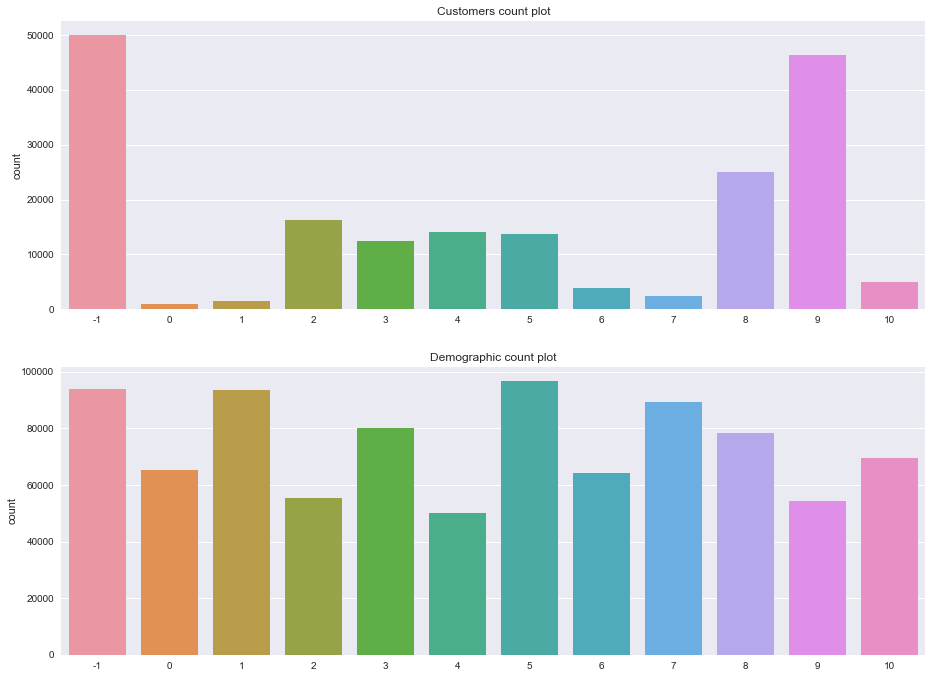

In [71]:
# Visualization
fig = plt.figure()
ax1=fig.add_axes([0,1.2,2,1], title='Demographic count plot')
ax2=fig.add_axes([0,2.4,2,1], title='Customers count plot')
sns.set(style="darkgrid")
sns.countplot(clusters_full_azdias, label='demographic', ax=ax1)
sns.countplot(clusters_full_customers, label='customer', ax=ax2)
ax.legend();

**Notes**  
The above visualization give the imporession that customers of the company are qualitatively different from the population and we would like to know in which characteristics.

However, the plot is a little bit misleading as it is in absolute units. For now, underrepresented customers seem to be in clusters 0, 1, 5, 6,7 and 10. Overrepresented as customers of the company seem to be individuals of cluster 9. We are going to check that in more detail.

In [72]:
# Check cluster distribution of customers
total_cust = len(clusters_full_customers)

cluster, counts = np.unique(clusters_full_customers, return_counts = True)
dict_clusters_full_customers = dict(zip(cluster, counts))

cluster_prop_cust = {}

# Calculate percentages...
for cluster, num in dict_clusters_full_customers.items():
    print("Cluster {}:".format(cluster), round((num / total_cust)*100,2),"%")
    cluster_prop_cust[cluster] = num/total_cust

Cluster -1: 26.1 %
Cluster 0: 0.53 %
Cluster 1: 0.78 %
Cluster 2: 8.52 %
Cluster 3: 6.46 %
Cluster 4: 7.37 %
Cluster 5: 7.18 %
Cluster 6: 2.0 %
Cluster 7: 1.3 %
Cluster 8: 13.07 %
Cluster 9: 24.16 %
Cluster 10: 2.54 %


In [73]:
# Check cluster distribution of general population
total_pop = len(clusters_full_azdias)

cluster, counts2 = np.unique(clusters_full_azdias, return_counts = True)
dict_clusters_full_azdias = dict(zip(cluster, counts2))

cluster_prop_pop = {}

for cluster, num in dict_clusters_full_azdias.items():
    print("Cluster {}:".format(cluster), round((num / total_pop)*100,2),"%")
    cluster_prop_pop[cluster] = num/total_pop

Cluster -1: 10.52 %
Cluster 0: 7.31 %
Cluster 1: 10.51 %
Cluster 2: 6.22 %
Cluster 3: 8.99 %
Cluster 4: 5.63 %
Cluster 5: 10.87 %
Cluster 6: 7.22 %
Cluster 7: 10.04 %
Cluster 8: 8.79 %
Cluster 9: 6.09 %
Cluster 10: 7.8 %


In [74]:
# Calculate differences
cluster_prop_diff = {}

for i in range(-1,11):
    diff = (cluster_prop_cust[i] - cluster_prop_pop[i])
    cluster_prop_diff[i] = diff*100

for cluster, perc in cluster_prop_diff.items():
    print("Cluster: "+str(cluster)+" - Difference: "+str(perc.round(2))+"%")

Cluster: -1 - Difference: 15.57%
Cluster: 0 - Difference: -6.78%
Cluster: 1 - Difference: -9.74%
Cluster: 2 - Difference: 2.3%
Cluster: 3 - Difference: -2.53%
Cluster: 4 - Difference: 1.74%
Cluster: 5 - Difference: -3.69%
Cluster: 6 - Difference: -5.22%
Cluster: 7 - Difference: -8.74%
Cluster: 8 - Difference: 4.28%
Cluster: 9 - Difference: 18.07%
Cluster: 10 - Difference: -5.26%


**Notes:**  
Overrepresented clusters (customers over population) are: 
- 9: +18.07%
- -1: +15.57%
- 8: +4.28%

Underrepresented clusters:
- 1: -9.74%
- 7: -8.74%
- 0: -6.8%

In a next step we will have a look at cluster 9 and 1 to see what the characteristics of those people are that are overrepresented (9) and underrepresented (1).

In [75]:
# Reverse scaling, transformation and pca
cluster = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)), columns=sub1.columns)
cluster

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MS,PRAEGENDE_JUGENDJAHRE_DEC,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,1.866835,0.976900,1.746704,4.534506,1.924207,3.709440,3.953400,3.711475,0.101735,2.327463,...,0.023233,0.054054,0.116617,0.132143,0.308003,0.327861,0.865175,87.799178,4.366607,2.019686
1,1.786907,1.995758,1.107904,4.346833,2.250067,4.190556,3.778276,4.202132,0.028595,2.197702,...,0.014414,0.057275,0.122491,0.142240,0.307834,0.307501,1.044349,85.585739,4.343405,2.079002
2,3.364003,1.938942,4.210196,1.708311,4.088632,2.190415,2.202432,2.234867,0.910870,2.141199,...,0.178175,0.070038,0.087432,0.030157,0.028695,0.013819,0.069898,66.857522,1.975421,3.653259
3,3.553059,1.925108,3.740091,1.586169,4.339228,2.620748,1.782636,3.018848,0.035555,2.027499,...,0.247121,0.089407,0.151212,0.076939,0.057547,0.025211,2.127535,63.638717,2.623474,3.353658
4,3.777925,1.035557,3.459417,1.358651,4.770983,1.145587,1.454756,4.102556,0.092530,1.728056,...,0.035278,0.056235,0.199479,0.136603,0.317934,0.190390,2.266343,57.678319,4.171747,2.706380
5,3.588712,1.958512,2.558509,1.882442,4.294826,2.215018,1.689267,4.301032,0.071896,2.047369,...,0.037076,0.059073,0.166576,0.146677,0.330854,0.205747,1.835530,63.086433,4.217935,2.656257
6,2.007339,0.983926,3.379245,3.925566,2.120843,3.749024,4.110871,1.819064,0.335106,2.218866,...,0.245875,0.078891,0.123066,0.063414,0.042503,0.003046,0.533574,86.662790,2.309570,3.272849
7,1.933806,1.969997,2.350830,3.932955,2.247277,4.380774,3.983215,2.767504,0.197098,2.243870,...,0.237911,0.085649,0.135758,0.070983,0.040593,0.021753,0.801394,86.281282,2.436447,3.221538
8,3.229246,1.118399,4.564899,1.667131,4.278054,2.207514,1.770948,2.153373,0.027064,2.345241,...,0.234852,0.080546,0.125241,0.071190,0.044993,0.026471,2.117988,65.792565,2.467195,3.281071
9,3.299215,1.054642,4.793719,1.628614,4.315473,1.470372,2.088865,1.942068,0.959398,2.018304,...,0.165548,0.065012,0.104967,0.046330,0.023371,0.014122,0.101531,65.287012,2.028539,3.612382


**Notes:**   
After reversing the transformation, scaling and pca we get the average number of a feature in each cluster. The information about the variable coding are based on the data dictionary. For example `ALTERSKATEGORIE_GROB` with a value of `3.2992` in cluster 9:
- Category 3: 46 - 60 years old  
- Category 4: > 60 years old
- Hence, 3.2992 corresponds to an average age of roughly 50 years in that cluster.

#### Cluster 9: Overrepresented
- Age (3.2992): Corresponds to an average age of ~50
- Gender (1.05): Predominantly male 
- People in this cluster seem to not actively preparing for old-age and having low financial interest
- not socially-minded, 
- religious

#### Cluster 1: Underrepresented
- Age (1.79): Under 30 
- Gender (1.99): Predominantly female
- Low financial interest, no money-savers
- socially-minded, family-minded, not religious

**Conclusion**  
One possible suggestion would be to target female customers under 30, focusing on social topics and family-oriented themes.

### Compare Customer Data to Demographics Data

### What kind of people are part of a cluster that is overrepresented in the customer data compared to the general population?
People in cluster 9 are overrepresented as customers in comparison to the total population. A typical individual in this cluster is roughly 50 years old and male. This individual does not actively prepare for old-age and having low financial interest. Moreover, a typical individual of this cluster is relatively religious and not socially minded. 

### What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?
The group of customers in cluster 1 are the most underrpresented part in terms of percentage points compared to the demographic distribution. Individuals in this cluster are on average under 30 and female. Moreover, they have low financial interest and are no money-saver. These individuals are relatively unreligious. They are socially as well as family-minded.

In [76]:
print("End of notebook!!!")

End of notebook!!!
